# Copy instead of modifying to preserve attack parameters

In [1]:
AGENT_NAME = 'default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_500'
DATASET_NAME = 'citylearn_challenge_2022_phase_2' #only action is electrical storage
SURROGATE_PATH = 'surrogates/imitator.pth'
RUNS = 5
TRIAL = 1

In [2]:
from stable_baselines3 import PPO

from citylearn.data import DataSet

from art.estimators.classification import PyTorchClassifier as classifier
from art.attacks.evasion import FastGradientMethod as FGM

import pandas as pd
import numpy as np
import os
import torch
from torch.nn import CrossEntropyLoss

import KBMproject.utilities as utils

from joblib import Parallel, delayed

%matplotlib inline

In [3]:
schema = DataSet.get_schema(DATASET_NAME)

Define RL agent

In [4]:
agents = []
path = os.path.join(os.getcwd(), '..',AGENT_NAME)
path = os.path.normpath(path) #resolve '..'
for _ in range (RUNS):
    agents.append(PPO.load(path))

Create environments

In [5]:
envs = []
for _ in range (RUNS):
    envs.append(utils.make_discrete_env(schema=schema,  
                            action_bins=agents[0].action_space[0].n,
                            seed=42))

In [6]:
path = os.path.join(os.getcwd(), '..',SURROGATE_PATH)
path = os.path.normpath(path) #resolve '..'
imitator = torch.load(path,)

In [7]:
path = os.path.join(os.getcwd(), '..','..','observation_masks.csv') #get adversary from parent directory
path = os.path.normpath(path) #resolve '..'
observation_masks = pd.read_csv(path)

In [8]:
kwargs = dict(norm=np.inf,
        eps=0.05,
        #num_random_init=2,
        )
attacks =[]
for run in range (RUNS):
    attacks.append(FGM(estimator=classifier(
                        model=imitator,
                        loss=CrossEntropyLoss(), 
                        nb_classes=agents[run].action_space[0].n, 
                        input_shape=agents[run].observation_space.shape,
                        device_type='gpu',
                        clip_values = (agents[run].observation_space.low.min(),agents[run].observation_space.high.max())
                        ),
                    **kwargs))

In [9]:
%%time
%%capture
results = Parallel(n_jobs=RUNS, verbose=10, prefer='threads')(delayed(
    utils.eval_untargeted_attack)(agent, env, attack) for agent, env, attack in zip(agents, envs, attacks)) 


CPU times: total: 9min 35s
Wall time: 5min 42s


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 868.8min finished

Results is a list of tupples for each run, of the format(KPIs, observations, perturbed observations, epsilons)

In [10]:
kpis = [results[i][0] for i in range(len(results))]
df_kpis = pd.concat(kpis, axis='columns',keys=range(RUNS))

In [11]:
df_kpis[['mean', 'std', 'variance']] = df_kpis.agg(['mean','std', 'var'], axis='columns')

In [12]:
df_kpis

,0,1,2,3,4,mean,std,variance
cost_function,,,,,,,,
annual_peak_average,1.009986,1.009986,1.009986,1.009986,1.009986,1.009986,0.000000e+00,0.000000e+00
carbon_emissions_total,0.891395,0.891395,0.891395,0.891395,0.891395,0.891395,1.241267e-16,1.540744e-32
cost_total,0.810279,0.810279,0.810279,0.810279,0.810279,0.810279,1.241267e-16,1.540744e-32
daily_one_minus_load_factor_average,1.070906,1.070906,1.070906,1.070906,1.070906,1.070906,0.000000e+00,0.000000e+00
daily_peak_average,0.939351,0.939351,0.939351,0.939351,0.939351,0.939351,0.000000e+00,0.000000e+00
electricity_consumption_total,0.899524,0.899524,0.899524,0.899524,0.899524,0.899524,0.000000e+00,0.000000e+00
monthly_one_minus_load_factor_average,0.991022,0.991022,0.991022,0.991022,0.991022,0.991022,1.241267e-16,1.540744e-32
ramping_average,1.224792,1.224792,1.224792,1.224792,1.224792,1.224792,0.000000e+00,0.000000e+00
zero_net_energy,1.109547,1.109547,1.109547,1.109547,1.109547,1.109547,0.000000e+00,0.000000e+00


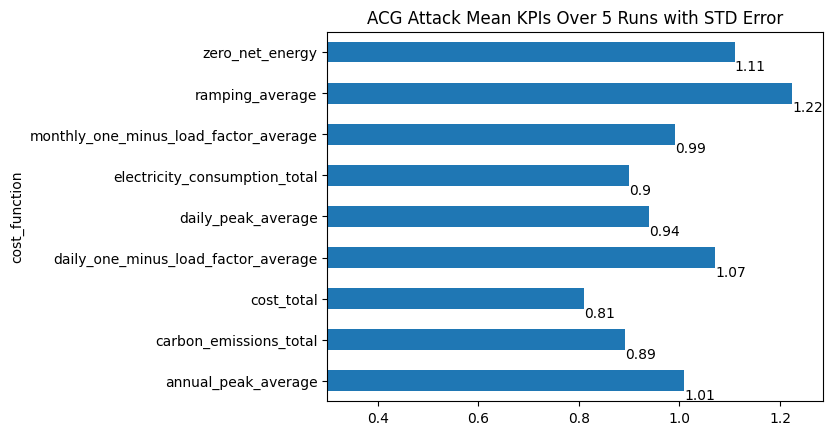

In [13]:
ax = df_kpis['mean'].plot.barh(xerr = df_kpis['std'], xlim=0.3, title='ACG Attack Mean KPIs Over 5 Runs with STD Error')
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width(), 
            i.get_y()-0.2,
            str(round((i.get_width()), 2)), 
            fontsize=10, 
            #color='dimgrey'
            )

FGSM using the same parameters in a whitebox attack has an ASR of 0.7.

Increasing the number of restarts decreases the ASR, likely because of differences between the surrogate and vicitm models

In [14]:
ASRs = [results[i][3] for i in range(len(results))]
print(f'For 5 runs of the random attack \nthe mean ASR is: {np.mean(ASRs):.3f}\nthe STD is: {np.std(ASRs):.3f}')

For 5 runs of the random attack 
the mean ASR is: 0.585
the STD is: 0.000


In [15]:
#df_kpis.to_csv(f'{RUNS} run KPIs {TRIAL}.csv')

In [17]:
for run in range(RUNS):
        np.savetxt(f'run {run} obs {TRIAL}.csv', results[run][1].astype(float), delimiter=",")
        np.savetxt(f'run {run} adv_obs {TRIAL}.csv', results[run][2].astype(float), delimiter=",")